In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import iapws95_light

# Cython-backend imports
import float_phi_functions
import float_mix_functions
import iapws95_light_perf
import mixtureWLMA
from time import perf_counter
import scipy.optimize

wlma = mixtureWLMA.WLMA()
K = wlma.K
p_m0 = wlma.p_m0
rho_m0 = wlma.rho_m0
v_m0 = 1.0 / rho_m0
c_v_m0 = wlma.c_v_m0
R_a = wlma.R_a
gamma_a = wlma.gamma_a
rhoc = mixtureWLMA.rhoc
Tc = mixtureWLMA.Tc

def prim_to_cons(yw, T, rhow, ya):
# Compute dependent quantities
  p_target = float_phi_functions.p(rhow, T)
  if p_target < 1e5 or p_target > 100e6:
    # Skip
    return (np.nan, np.nan, np.nan)
  rhom = rho_m0* (1.0 + (p_target - p_m0) / K)
  rhoa = p_target / (R_a * T)
  rho_mix = 1.0/(yw / rhow + (1 - yw - ya) / rhom + ya / rhoa)
  uw_target = float_phi_functions.u(rhow, T)
  um_target = c_v_m0 * T \
    + float_mix_functions.magma_mech_energy(p_target, K , p_m0, rho_m0)
  ua_target = R_a / (gamma_a - 1.0) * T
  u_target = yw*uw_target + (1-yw-ya)*um_target + ya*ua_target
  vol_energy = rho_mix * u_target
  return (vol_energy, rho_mix, p_target)

vec_yw = np.linspace(0.01, 0.9999, 8) # 125
vec_T = np.linspace(280, 1500, 12) # 130
vec_rhow = np.linspace(0.5, 1050, 14) # 60
vec_ya = np.linspace(0.01, 0.99, 24)

mg_yw, mg_T, mg_rhow, mg_ya = np.meshgrid(
  vec_yw, vec_T, vec_rhow, vec_ya, indexing="ij")

mg_p_target = np.empty_like(mg_yw)
mg_vol_energy = np.empty_like(mg_yw)
mg_rho_mix = np.empty_like(mg_yw)

mg_p_calc = np.empty_like(mg_yw)
mg_T_calc = np.empty_like(mg_yw)

# Iteratively load complete conservative state
for i, j, k, l in np.ndindex(mg_yw.shape):
  mg_vol_energy[i,j,k,l], mg_rho_mix[i,j,k,l], mg_p_target[i,j,k,l] = \
    prim_to_cons(mg_yw[i,j,k,l], mg_T[i,j,k,l], mg_rhow[i,j,k,l], mg_ya[i,j,k,l])

In [2]:
# Simulate input and grab solution
i, j, k, l = 1, 3, 3, 4
input = {
  "vol_energy": mg_vol_energy[i,j,k,l],
  "rho_mix": mg_rho_mix[i,j,k,l],
  "ya" : mg_ya[i,j,k,l],
  "yw": mg_yw[i,j,k,l],
}
solution = {
  "p": mg_p_target[i,j,k,l],
  "rhow": mg_rhow[i,j,k,l],
  "T": mg_T[i,j,k,l],
  "x": 0,
}
solution["alphaw"] = input["rho_mix"] * input["yw"] / solution["rhow"]
if solution["p"] == float_mix_functions.prho_sat(solution["T"])["psat"]:
    _out = float_mix_functions.prho_sat(solution["T"])
    rho_satl, rho_satv = _out["rho_satl"], _out["rho_satv"]
    solution["x"] = (1/solution["rhow"] - 1/rho_satl) / (1/rho_satv - 1/rho_satl)
input, solution, f'p - p_sat = {solution["p"] - float_mix_functions.prho_sat(solution["T"])["psat"]}'

({'vol_energy': 515928904.9717343,
  'rho_mix': 326.2237724926067,
  'ya': 0.18043478260869567,
  'yw': 0.15141428571428572},
 {'p': 14523378.292921769,
  'rhow': 242.69230769230768,
  'T': 612.7272727272727,
  'x': 0.26926290333426617,
  'alphaw': 0.20352906923449765},
 'p - p_sat = 0.0')

In [3]:
alphaw = 0.20352906923449765
T = 612.7272727272727
_out = float_mix_functions.kernel2_WLMA(
  alphaw, T,
  input["vol_energy"], input["rho_mix"], input["yw"], input["ya"],
  K, p_m0, rho_m0, c_v_m0, R_a, gamma_a)
_out

(array([ 0.00000000e+00, -1.11022302e-16]),
 array([[ 0.18855089,  0.00218344],
        [ 1.        , -0.00779267]]),
 {'x': 0.26926290333426617,
  'ew': 1809657.1551336658,
  'v': 0.004120443740095087,
  'ul': 1567767.5678292173,
  'uv': 2466107.3848227374,
  'vl': 0.0016338850015996118,
  'vv': 0.010868572393381286,
  'dewdT': 8712.319329331793,
  'dpsatdT': 182466.55307075247,
  'partial_dxdT': 0.005395772583480845,
  'partial_dxdv': 108.28736887075796,
  'partial_dxdd': -0.5919999235695015,
  'dv0dT': 8.624034251056024e-06,
  'dv1dT': -0.00020845862575459814,
  'du0dT': 6733.356502653395,
  'du1dT': -3918.9631930297815},
 14523378.292921769,
 1)

In [4]:
# Objective function in variables (T, alphaw)
def f_Talpha(T, alphaw, input:dict, full_output=False) -> np.array:
  # Extract inputs
  rho_mix = input["rho_mix"]
  ya = input["ya"]
  yw = input["yw"]

  # Compute dependents
  ym = 1.0 - input["yw"] - input["ya"]
  # Check validity
  if ym < 0:
    print(f"ym=={ym}")
  # Compute water phase density as dependent
  rhow = input["rho_mix"] * input["yw"] / alphaw

  # Set bound on rhow based on pressure bound [, 1 GPa]
  rhow = np.clip(rhow, 1e-9, 1260)

  # Take water pressure as mixture pressure TODO: consensus pressure
  pmix = float_mix_functions.p(rhow, T)
  # Approximate compressibles pressure consensus
  # alpham_approx = input["rho_mix"] * ym / rho_m0
  # alphaa_approx = np.clip(1.0 - alphaw - alpham_approx, 0.0, 1.0)
  # pmix = alphaw / (alphaw + alphaa_approx) * float_mix_functions.p(rhow, T) \
  #   + input["ya"] * input["rho_mix"] * R_a * T / (alphaw + alphaa_approx)
  # TODO: Pressure correction for asymptotic correctness
  
  rhoa = pmix / (R_a * T)
  rhom = rho_m0 * (1.0 + (pmix - p_m0) / K)
  # Compute other phase volume fractions
  alphaa = input["rho_mix"] * input["ya"] / rhoa
  alpham = input["rho_mix"] * ym / rhom
  # Compute energies
  ew = np.clip(float_mix_functions.u(rhow, T), 0, 5e6)
  ea = R_a/(gamma_a - 1.0) * T
  em = c_v_m0 * T + float_mix_functions.magma_mech_energy(pmix, K, p_m0, rho_m0)
  # Compute energy fractions
  emix = input["vol_energy"] / input["rho_mix"]
  epsw = input["yw"] * ew / emix
  epsa = input["ya"] * ea / emix
  epsm = ym * em / emix
  # [efrac, volfrac, pmismatch, Tmismatch] or [efrac, volfrac]
  if not full_output:
    return np.array([epsw + epsa + epsm - 1.0, alphaw + alphaa + alpham - 1.0])
  else:
    d = rhow / rhoc
    t = Tc / T
    # Compute Jacobian
    _f, _C, _D, _lv_hypothetical, _p_ = float_mix_functions.kernel4_WLMA(
      d, T, pmix, T,
      input["vol_energy"], input["rho_mix"], input["yw"], input["ya"],
      K, p_m0, rho_m0, c_v_m0, R_a, gamma_a)
    dewdd = _D[0,0]
    dewdT = _D[0,1]
    dpdd = _D[2,0]
    dpdT = _D[2,1]
    # Chain rule for d pressure w.r.t. alphaw
    dpdaw = - 1.0 / rhoc * dpdd * rho_mix * yw / (alphaw * alphaw)

    J = np.zeros((2,2))
    # Gradient of energy condition w.r.t. [T, alphaw]
    J[0,0] = 1/emix * (yw * dewdT + ya * R_a / (gamma_a - 1.0) + ym * c_v_m0
      + ym * pmix * rho_m0 / (K * rhom * rhom) * dpdT)
    J[0,1] = 1/emix * (-yw / rhoc * dewdd * rho_mix * yw / (alphaw*alphaw)
      + ym * pmix * rho_m0 / (K * rhom * rhom) * dpdaw)
    # Gradient of volume condition w.r.t. [T, alphaw]
    J[1,0] = rho_mix * ya * R_a / pmix \
      + rho_mix * (ya * (-R_a * T / (pmix*pmix))  + ym * (-rho_m0 / (K * rhom * rhom))) * dpdT
    J[1,1] = 1 - rho_mix * ya * R_a * T /(pmix * pmix)* dpdaw \
      - rho_mix * ym * rho_m0 / (K * rhom * rhom) * dpdaw

    return \
      np.array([epsw + epsa + epsm - 1.0, alphaw + alphaa + alpham - 1.0]),\
      J, \
      (np.array([epsw, epsa, epsm]), np.array([alphaw, alphaa, alpham]))

In [5]:
# Objective function in variables (T, x)
def f_Tx(T, x, input:dict, full_output=False) -> np.array:
  ''' Objective function under extrapolative liquid-vapour equilibrium.
  Steam fraction x may be outside [0, 1]. '''
  if T > Tc:
    print("supercrit temperature, giving up")
    return None
  # Extract inputs
  rho_mix = input["rho_mix"]
  ya = input["ya"]
  yw = input["yw"]

  # Compute dependents
  ym = 1.0 - input["yw"] - input["ya"]
  # Check validity
  if ym < 0:
    print(f"ym=={ym}")
  
  # Compute saturation state
  _out = float_mix_functions.prho_sat(T)
  pmix = _out["psat"]
  rho_satl = _out["rho_satl"]
  rho_satv = _out["rho_satv"]

  # Compute Jacobian with d = 1.0 (dummy value)
  _f, _C, _D, _lv_hypothetical, _p_ = float_mix_functions.kernel4_WLMA(
    1.0, T, pmix, T,
    input["vol_energy"], input["rho_mix"], input["yw"], input["ya"],
    K, p_m0, rho_m0, c_v_m0, R_a, gamma_a)
  # Extracted values
  dvldT = _lv_hypothetical["dv0dT"]
  dvvdT = _lv_hypothetical["dv1dT"]
  duldT = _lv_hypothetical["du0dT"]
  duvdT = _lv_hypothetical["du1dT"]
  dpdT = _lv_hypothetical['dpsatdT']
  ul = _lv_hypothetical["ul"]
  uv = _lv_hypothetical["uv"]
  vl = _lv_hypothetical["vl"]
  vv = _lv_hypothetical["vv"]
  # Compute water density
  rhow = 1.0 /(x * vv + (1-x) * vl)
  # Compute p, T dependents
  rhoa = pmix / (R_a * T)
  rhom = rho_m0 * (1.0 + (pmix - p_m0) / K)
  # Compute phase volume fractions
  alphaw = input["rho_mix"] * input["yw"] / rhow
  alphaa = input["rho_mix"] * input["ya"] / rhoa
  alpham = input["rho_mix"] * ym / rhom
  # Compute energies
  ew = x * uv + (1 - x) * ul
  ea = R_a/(gamma_a - 1.0) * T
  em = c_v_m0 * T + float_mix_functions.magma_mech_energy(pmix, K, p_m0, rho_m0)
  # Compute energy fractions
  emix = input["vol_energy"] / input["rho_mix"]
  epsw = input["yw"] * ew / emix
  epsa = input["ya"] * ea / emix
  epsm = ym * em / emix
  # [efrac, volfrac, pmismatch, Tmismatch] or [efrac, volfrac]
  if not full_output:
    return np.array([epsw + epsa + epsm - 1.0, alphaw + alphaa + alpham - 1.0])
  else:
    J = np.zeros((2,2))
    dewdT = x * duvdT + (1-x) * duldT
    # Gradient of energy condition w.r.t. [T, x]
    J[0,0] = 1/emix * (yw * dewdT + ya * R_a / (gamma_a - 1.0) + ym * c_v_m0
      + ym * pmix * rho_m0 / (K * rhom * rhom) * dpdT)
    J[0,1] = yw / emix * (uv - ul)
    # Gradient of volume condition w.r.t. [T, x]
    J[1,0] = yw * (x * dvvdT + (1-x) * dvldT) * rho_mix + rho_mix * ya * R_a / pmix \
      + rho_mix * (ya * (-R_a * T / (pmix*pmix))  + ym * (-rho_m0 / (K * rhom * rhom))) * dpdT
    J[1,1] = yw * rho_mix * (vv - vl)

    return \
      np.array([epsw + epsa + epsm - 1.0, alphaw + alphaa + alpham - 1.0]),\
      J, \
      (np.array([epsw, epsa, epsm]), np.array([alphaw, alphaa, alpham]))

In [6]:
''' Debug cell '''
_f, _C, _D, _lv_hypothetical, _p_ = float_mix_functions.kernel4_WLMA(
  1.2, 300, 1e6, 300,
  input["vol_energy"], input["rho_mix"], input["yw"], input["ya"],
  K, p_m0, rho_m0, c_v_m0, R_a, gamma_a)
_dpdd = _D[2,0]
_phirall = float_mix_functions.fused_phir_all(3.5, 647/300)
_dpdd = rhoc * 412 * 300 * (1.0 + 2.0 * 3.5 * _phirall["phir_d"]
             + 3.5 * 3.5 * _phirall["phir_dd"])
_dpdaw = 1.0 / rhoc * _dpdd * input["rho_mix"] * 0.5 / (.1 * .1)
1 / (input["vol_energy"] / input["rho_mix"]) * \
  input["rho_mix"] * 0.1 * R_a * 300 /(1e6 * 1e6)* _dpdaw, _dpdaw, _dpdd

(0.10820765431648284, 60927517047.01139, 1202773197.0135496)

Red contour: 1 GPa


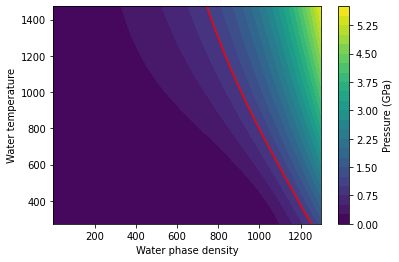

In [7]:
''' Converting pressure limits to density limits '''
T_test_vec = np.linspace(273.16, 1473.16, 101)
rhow_test_vec = np.linspace(0.001, 1300, 101)
mg_rhow_test, mg_T_test = np.meshgrid(rhow_test_vec, T_test_vec)
mg_pw = np.zeros(mg_T_test.shape)
for i, j in np.ndindex(mg_T_test.shape):
  mg_pw[i,j] = float_mix_functions.p(mg_rhow_test[i,j], mg_T_test[i,j])
  
plt.contourf(mg_rhow_test, mg_T_test, mg_pw/1e9, levels=25)
plt.colorbar(label="Pressure (GPa)")
plt.contour(mg_rhow_test, mg_T_test, mg_pw/1e9, levels=[1], colors=["red"])
plt.xlabel("Water phase density")
plt.ylabel("Water temperature")
print("Red contour: 1 GPa")

## Test area

In [8]:
''' Compute loop: objective function sampling '''
T_test_vec = np.linspace(273.16, 1273.16, 101)
alpha_test_vec = np.linspace(1e-5, 1-1e-5, 100)
mg_alpha_test, mg_T_test = np.meshgrid(alpha_test_vec, T_test_vec)
mg_f = np.zeros((*mg_T_test.shape, 2))
mg_J = np.zeros((*mg_T_test.shape, 2, 2))
mg_df = np.zeros((*mg_T_test.shape, 2))
for i, j in np.ndindex(mg_T_test.shape):
  mg_f[i,j,:], mg_J[i,j,...], _ = f_Talpha(mg_T_test[i,j], mg_alpha_test[i,j], input, True)
  mg_df[i,j,:] = -np.linalg.solve(mg_J[i,j,...], mg_f[i,j,:])

In [9]:
''' Compute loop for LV '''
T_test_vec_LV = np.linspace(273.16, Tc-0.01, 101)
x_test_vec_LV = np.linspace(1e-5, 1-1e-5, 100)
mg_x_test_LV, mg_T_test_LV = np.meshgrid(x_test_vec_LV, T_test_vec_LV)
mg_f_LV = np.zeros((*mg_T_test_LV.shape, 2))
mg_J_LV = np.zeros((*mg_T_test_LV.shape, 2, 2))
mg_df_LV = np.zeros((*mg_T_test_LV.shape, 2))
for i, j in np.ndindex(mg_T_test_LV.shape):
  mg_f_LV[i,j,:], mg_J_LV[i,j,...], _ = f_Tx(mg_T_test_LV[i,j], mg_x_test_LV[i,j], input, True)
  mg_df_LV[i,j,:] = -np.linalg.solve(mg_J_LV[i,j,...], mg_f_LV[i,j,:])

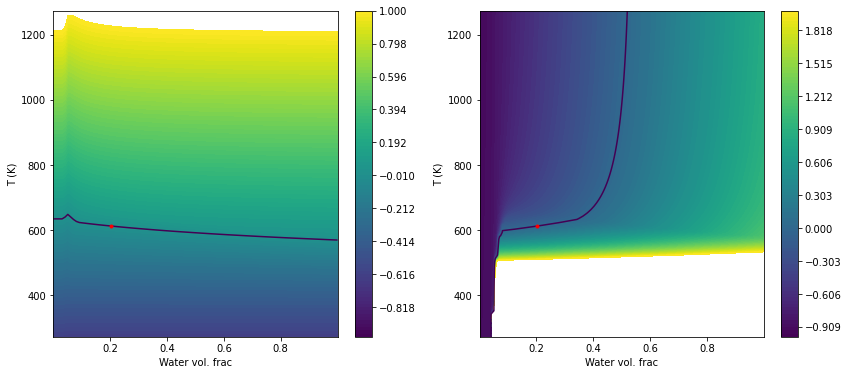

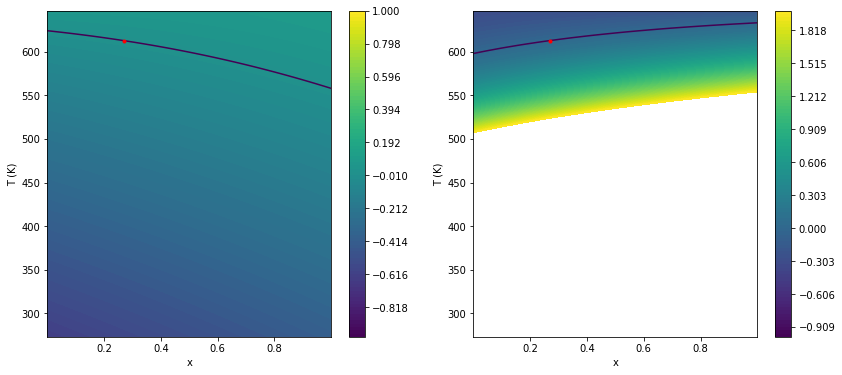

In [10]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.contourf(mg_alpha_test, mg_T_test, mg_f[...,0], np.linspace(-1,1,100))
plt.colorbar()
plt.xlabel("Water vol. frac")
plt.ylabel("T (K)")
plt.contour(mg_alpha_test, mg_T_test, mg_f[...,0], levels=[0])
plt.plot(solution["alphaw"], solution["T"], 'r.')
plt.subplot(1,2,2)
plt.contourf(mg_alpha_test, mg_T_test, mg_f[...,1], levels=np.linspace(-1,2,100))
plt.colorbar()
plt.xlabel("Water vol. frac")
plt.ylabel("T (K)")
plt.contour(mg_alpha_test, mg_T_test, mg_f[...,1], levels=[0])
plt.plot(solution["alphaw"], solution["T"], 'r.')

plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.contourf(mg_x_test_LV, mg_T_test_LV, mg_f_LV[...,0], np.linspace(-1,1,100))
plt.colorbar()
plt.xlabel("x")
plt.ylabel("T (K)")
plt.contour(mg_x_test_LV, mg_T_test_LV, mg_f_LV[...,0], levels=[0])
plt.plot(solution["x"], solution["T"], 'r.')
plt.subplot(1,2,2)
plt.contourf(mg_x_test_LV, mg_T_test_LV, mg_f_LV[...,1], levels=np.linspace(-1,2,100))
plt.colorbar()
plt.xlabel("x")
plt.ylabel("T (K)")
plt.contour(mg_x_test_LV, mg_T_test_LV, mg_f_LV[...,1], levels=[0])
plt.plot(solution["x"], solution["T"], 'r.')

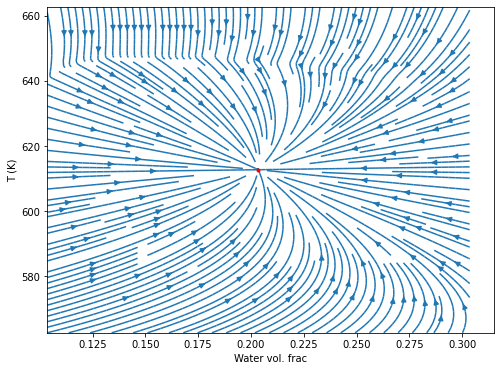

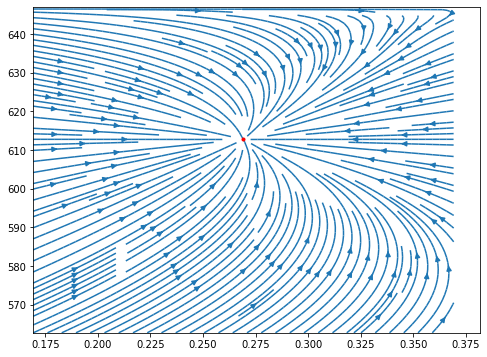

In [11]:
%matplotlib inline
''' Plot basin of attraction '''
T_basin_vec = np.linspace(solution["T"]-50, solution["T"]+50, 101)
alpha_basin_vec = np.linspace(solution["alphaw"]-0.1, solution["alphaw"]+0.1, 100)
mg_alpha_basin, mg_T_basin = np.meshgrid(alpha_basin_vec, T_basin_vec)
mg_df = np.zeros((*mg_alpha_basin.shape, 2))
mg_J = np.zeros((*mg_alpha_basin.shape, 2, 2))

for i, j in np.ndindex(mg_T_basin.shape):
  _f, _J, _ = f_Talpha(mg_T_basin[i,j], mg_alpha_basin[i,j], input, True)
  mg_df[i,j,:] = (-np.linalg.solve(_J, _f))[::-1]
  mg_J[i,j,...] = _J
plt.figure(figsize=(8,6))
plt.streamplot(mg_alpha_basin, mg_T_basin, mg_df[...,0], mg_df[...,1], density=2)
plt.plot(solution["alphaw"], solution["T"], '.r')
plt.xlabel("Water vol. frac")
plt.ylabel("T (K)")

if False:
  # Plot (T, alphaw) Jacobian components
  plt.figure(figsize=(12,12))
  plt.subplot(2,2,1)
  plt.contourf(mg_alpha_test, mg_T_test, mg_J[...,0,0])
  plt.colorbar()
  plt.subplot(2,2,2)
  plt.contourf(mg_alpha_test, mg_T_test, mg_J[...,0,1])
  plt.colorbar()
  plt.subplot(2,2,3)
  plt.contourf(mg_alpha_test, mg_T_test, mg_J[...,1,0])
  plt.colorbar()
  plt.subplot(2,2,4)
  plt.contourf(mg_alpha_test, mg_T_test, mg_J[...,1,1])
  plt.colorbar()

T_basin_vec_LV = np.linspace(solution["T"]-50, Tc-0.01, 101)
x_basin_vec_LV = np.linspace(solution["x"]-0.1, solution["x"]+0.1, 100)
mg_x_basin_LV, mg_T_basin_LV = np.meshgrid(x_basin_vec_LV, T_basin_vec_LV)
mg_df_LV = np.zeros((*mg_x_basin_LV.shape, 2))
mg_J_LV = np.zeros((*mg_x_basin_LV.shape, 2, 2))

for i, j in np.ndindex(mg_T_basin_LV.shape):
  _f, _J, _ = f_Tx(mg_T_basin_LV[i,j], mg_x_basin_LV[i,j], input, True)
  mg_df_LV[i,j,:] = (-np.linalg.solve(_J, _f))[::-1]
  mg_J_LV[i,j,...] = _J
plt.figure(figsize=(8,6))
plt.streamplot(mg_x_basin_LV, mg_T_basin_LV, mg_df_LV[...,0], mg_df_LV[...,1], density=2)
plt.plot(solution["x"], solution["T"], '.r')

In [12]:
# Set initial guess using perturbation to solution
_T_init = solution["T"] * 1#.05
_d_init = solution["rhow"]/rhoc * 1 #0.9
_p_init = float_mix_functions.p(_d_init*rhoc, _T_init)

_f, _C, _D, _lv_hypothetical, _p_ = float_mix_functions.kernel4_WLMA(
  _d_init, _T_init, _p_init, _T_init,
  input["vol_energy"], input["rho_mix"], input["yw"], input["ya"],
  K, p_m0, rho_m0, c_v_m0, R_a, gamma_a)

# Satisfy volume requirement
 
_p_init
if len(_lv_hypothetical) == 0:
  ''' Supercrit '''
# _lv_hypothetical["ew"], _lv_hypothetical

_lv_hypothetical

{'x': 0.26926290333426617,
 'ew': 1809657.1551336658,
 'v': 0.004120443740095087,
 'ul': 1567767.5678292173,
 'uv': 2466107.3848227374,
 'vl': 0.0016338850015996118,
 'vv': 0.010868572393381286,
 'dewdT': 8712.319329331793,
 'dpsatdT': 182466.55307075247,
 'partial_dxdT': 0.005395772583480845,
 'partial_dxdv': 108.28736887075796,
 'partial_dxdd': -0.5919999235695015,
 'dv0dT': 8.624034251056024e-06,
 'dv1dT': -0.00020845862575459814,
 'du0dT': 6733.356502653395,
 'du1dT': -3918.9631930297815}

## Plot basin using kernel2

Text(0, 0.5, 'T (K)')

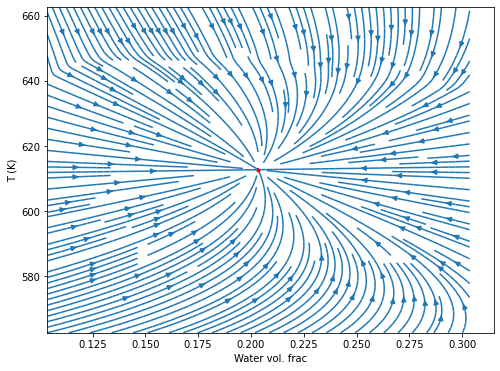

In [13]:
''' Plot basin of attraction '''
T_basin_vec = np.linspace(solution["T"]-50, solution["T"]+50, 101)
alpha_basin_vec = np.linspace(solution["alphaw"]-0.1, solution["alphaw"]+0.1, 100)
mg_alpha_basin, mg_T_basin = np.meshgrid(alpha_basin_vec, T_basin_vec)
mg_f = np.zeros((*mg_alpha_basin.shape, 2))
mg_J = np.zeros((*mg_alpha_basin.shape, 2, 2))
mg_df = np.zeros((*mg_alpha_basin.shape, 2))
mg_flags = np.zeros((*mg_alpha_basin.shape,))
for i, j in np.ndindex(mg_T_basin.shape):
  # E, V conditions w.r.t. [alpha_w, T]
  mg_f[i,j,:], mg_J[i,j,...], _, _, mg_flags[i,j] = float_mix_functions.kernel2_WLMA(
    mg_alpha_basin[i,j], mg_T_basin[i,j],
    input["vol_energy"], input["rho_mix"], input["yw"], input["ya"],
    K, p_m0, rho_m0, c_v_m0, R_a, gamma_a)
  mg_df[i,j,:] = (-np.linalg.solve(mg_J[i,j,...], mg_f[i,j,:]))
plt.figure(figsize=(8,6))
plt.streamplot(mg_alpha_basin, mg_T_basin, mg_df[...,0], mg_df[...,1], density=2)
plt.plot(solution["alphaw"], solution["T"], '.r')
plt.xlabel("Water vol. frac")
plt.ylabel("T (K)")

In [14]:
''' Define Newton + backtracking routine '''

def iterate_backtrack_box(U, fn:callable, append_log=None):
  ''' Backtracked Newton with box bounds. Takes callable fn that returns
  (f, fjac, ...). '''

  # Logging middleware
  if append_log is None:
    msg_list = []
  else:
    msg_list = append_log
  def log(msg) -> None:
    # print(msg) 
    msg_list.append(msg)

  # Compute Newton step
  _out = fn(*U)
  f_curr = _out[0]
  fnorm_curr = np.linalg.norm(f_curr)
  step = - np.linalg.solve(_out[1], _out[0])
  log(f"Init   | f: {f_curr}, U:{U}, step: {step} ")

  # Define box bounds
  U_min = np.array([1e-2, 273.16])
  U_max = np.array([1.0, 2273.15])
  # Modify step to remain in feasible set
  use_type = "scaling"
  if use_type == "scaling":
    step_size_factor = 1.0
    for i in range(len(U)):
      if U[i] + step[i] < U_min[i]:
        # i-th min bound is active 
        step_size_factor = np.minimum(step_size_factor, (U_min[i] - U[i])/ step[i])
      if U[i] + step[i] > U_max[i]:
        # i-th max bound is active
        step_size_factor = np.minimum(step_size_factor, (U_max[i] - U[i])/ step[i])
    step *= step_size_factor
  log(f"Bounds | f: {f_curr}, U:{U}, step: {step} ")

  ''' Backtracking '''
  # Greed ratio in (0,1) for Armijo conditions
  armijo_c = 0.1
  # Step reduction factor in (0, 1) used each iteration
  step_reduction_factor = 0.7
  # Set the step size factor (==1.0 the first time Armijo condition is checked)
  a = 1.0 / step_reduction_factor
  # Set minimum decrement of the objective value. Note that
  #   c * grad(norm(f)) dot J^{-1} f = c || f ||, since Newton sends model to 0
  min_decrement = armijo_c * fnorm_curr
  # Backtracking
  for i in range(12):
    a *= step_reduction_factor

    U_next = U + a * step
    box_active = False
    if use_type == "projection":
      for i in range(len(U)):
        if U_next[i] < U_min[i]:
          # i-th min bound is active
          U_next[i] = U_min[i] 
          box_active = True
        if U_next[i] > U_max[i]:
          # i-th max bound is active
          U_next[i] = U_max[i]
          box_active = True
    f_along_line = fn(*U_next)[0]
    
    log(f"Backtr | f: {f_along_line}, U:{U_next}, step: {a * step}," +
            f" f/req: {np.linalg.norm(f_along_line)}/{(1.0 - a * armijo_c) * fnorm_curr}")
    # Armijo condition: improvement is at least a portion of a * |f|
    if np.linalg.norm(f_along_line) <= (1.0 - a * armijo_c) * fnorm_curr:
      break
  else:
    log("Could not backtrack to a satisfactory step.")
    # raise ValueError("Could not backtrack to a satisfactory step.")
  return U_next, f_along_line, msg_list

# Set water seeding
# d0_range = np.linspace(0.1,1.1,51)
# T0_range = np.linspace(300, 1000, 52)
# mg_d0, mg_T0 = np.meshgrid(d0_range, T0_range, indexing="ij")
# mg_fnorms = np.empty_like(mg_d0)

In [552]:
''' Define Newton + backtracking routine '''

def iterate_backtrack_box(U, fn:callable, append_log=None):
  ''' Backtracked Newton with box bounds. Takes callable fn that returns
  (f, fjac, _, _, flag ...). '''

  # Logging middleware
  if append_log is None:
    msg_list = []
  else:
    msg_list = append_log
  def log(msg) -> None:
    # print(msg) 
    msg_list.append(msg)

  # Compute Newton step
  _out = fn(*U)
  f_curr = _out[0]
  flag_curr = _out[4]
  fnorm_curr = np.linalg.norm(f_curr)
  step = - np.linalg.solve(_out[1], _out[0])
  log(f"Init   | f: {f_curr}, U:{U}, step: {step} ")

  # Define box bounds
  U_min = np.array([1e-6, 273.16])
  U_max = np.array([1.0, 2273.15])
  # Modify step to remain in feasible set
  use_type = "scaling"
  if use_type == "scaling":
    step_size_factor = 1.0
    for i in range(len(U)):
      if U[i] + step[i] < U_min[i]:
        # i-th min bound is active; scale to step hitting just the boundary
        step_size_factor = np.minimum(step_size_factor, (U_min[i] - U[i])/ step[i])
      if U[i] + step[i] > U_max[i]:
        # i-th max bound is active
        step_size_factor = np.minimum(step_size_factor, (U_max[i] - U[i])/ step[i])
    if not (0 <= step_size_factor and step_size_factor <= 1):
      # Dump
      print(step_size_factor, U, step, U_min, U_max)
      print((U_min[i] - U[i])/ step[i])
      print((U_max[i] - U[i])/ step[i])
      raise ValueError("Bounds step failed, dumping. Check if initial is in bounds.")
    step *= step_size_factor
  log(f"Bounds | f: {f_curr}, U:{U}, step: {step} ")

  ''' Backtracking '''
  # Greed ratio in (0,1) for Armijo conditions
  armijo_c = 0.1
  # Step reduction factor in (0, 1) used each iteration
  step_reduction_factor = 0.5
  # Set the step size factor (==1.0 the first time Armijo condition is checked)
  a = 1.0 / step_reduction_factor
  # Set minimum decrement of the objective value. Note that
  #   c * grad(norm(f)) dot J^{-1} f = c || f ||, since Newton sends model to 0
  min_decrement = armijo_c * fnorm_curr
  # Backtracking
  for i in range(16):
    a *= step_reduction_factor

    U_next = U + a * step
    box_active = False
    if use_type == "projection":
      for i in range(len(U)):
        if U_next[i] < U_min[i]:
          # i-th min bound is active
          U_next[i] = U_min[i] 
          box_active = True
        if U_next[i] > U_max[i]:
          # i-th max bound is active
          U_next[i] = U_max[i]
          box_active = True

    _out_along_line = fn(*U_next)
    f_along_line = _out_along_line[0]
    log(f"Backtr | f: {f_along_line}, U:{U_next}, step: {a * step}," +
            f" f/req: {np.linalg.norm(f_along_line)}/{(1.0 - a * armijo_c) * fnorm_curr}")
    # Armijo condition: improvement is at least a portion of a * |f|
    if np.linalg.norm(f_along_line) <= (1.0 - a * armijo_c) * fnorm_curr:
      break
  else:
    log("Could not backtrack to a satisfactory step.")
    # raise ValueError("Could not backtrack to a satisfactory step.")
  
  # Phase boundary backtracking
  transphasic_backtracking = True
  f_at_t_max = f_along_line
  if transphasic_backtracking:
    if _out_along_line[4] != flag_curr:
      # Identify phase boundary for b in (0, 1) with bisection
      t_min = 0.0
      t_max = 1.0
      for i in range(11):
        m = 0.5 * (t_min + t_max)
        U_m = U + m * a * step
        _out_along_line = fn(*U_m)
        f_along_line = _out_along_line[0]
        log(f"BdryBi | f: {f_along_line}, U:{U_m}, step: {m * a * step}," +
            f" flag/flag_curr: {_out_along_line[4]}/{flag_curr}")
        if _out_along_line[4] == flag_curr:
          t_min = m
        else:
          t_max = m
          f_at_t_max = f_along_line
      # Use smallest known step that switches zones
      U_m = U + t_max * a * step
      log(f"BdryLt | f: {f_at_t_max}, U:{U_m}, step: {t_max * a * step}," +
            f" flag/flag_curr: {_out_along_line[4]}/{flag_curr}")
      U_next = U_m
  # Load f corresponding to t_max
  f_along_line = f_at_t_max

  return U_next, f_along_line, msg_list

In [60]:
''' Newton + backtracking near solution'''

# Define callable
kern = lambda U0, U1: float_mix_functions.kernel2_WLMA(
    U0, U1,
    input["vol_energy"], input["rho_mix"], input["yw"], input["ya"],
    K, p_m0, rho_m0, c_v_m0, R_a, gamma_a)

mg_U0 = np.zeros((*mg_alpha_basin.shape, 2))
mg_U1 = np.zeros((*mg_alpha_basin.shape, 2))
mg_U2 = np.zeros((*mg_alpha_basin.shape, 2))
# Reduction factor
mg_a = np.zeros((*mg_alpha_basin.shape, 2))

for i, j in np.ndindex(mg_T_basin.shape):
  U0 = np.array([mg_alpha_basin[i,j], mg_T_basin[i,j]])
  mg_U0[i,j,:] = U0
  mg_U1[i,j,:] = iterate_backtrack_box(U0, kern)[0]
  mg_U2[i,j,:] = iterate_backtrack_box(mg_U1[i,j,:], kern)[0]

Text(0, 0.5, 'T (K)')

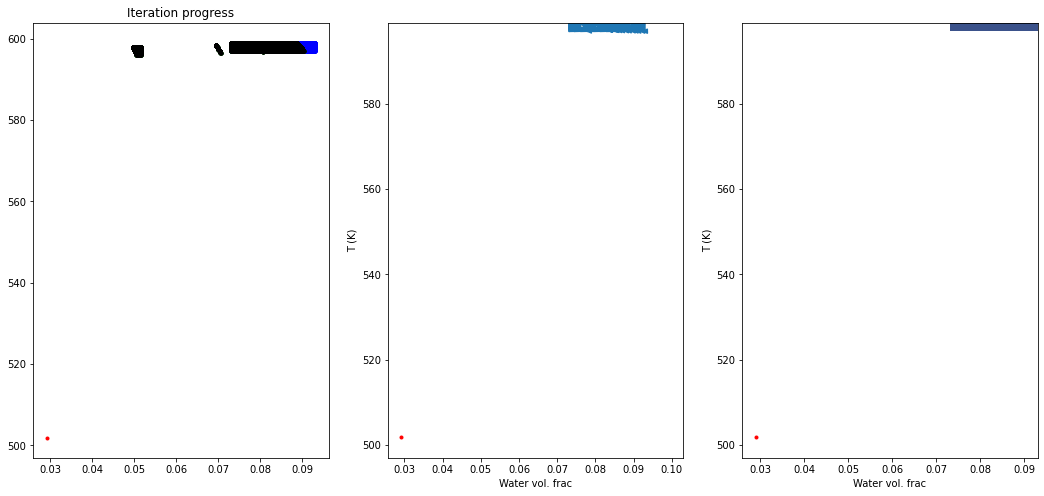

In [63]:
plt.figure(figsize=(18,8))
plt.subplot(1,3,1)
plt.scatter(mg_U0[...,0].ravel(), mg_U0[...,1].ravel(), c=["blue"], s=10)
plt.scatter(mg_U1[...,0].ravel(), mg_U1[...,1].ravel(), c=["green"], s=10)
plt.scatter(mg_U2[...,0].ravel(), mg_U2[...,1].ravel(), c=["black"], s=10)
plt.plot(solution["alphaw"], solution["T"], '.r')
plt.title("Iteration progress")

plt.subplot(1,3,2)
plt.streamplot(mg_alpha_basin, mg_T_basin, mg_df[...,0], mg_df[...,1], density=2)
plt.plot(solution["alphaw"], solution["T"], '.r')
plt.xlabel("Water vol. frac")
plt.ylabel("T (K)")

plt.subplot(1,3,3)
plt.contourf(mg_alpha_basin, mg_T_basin, mg_flags)
plt.plot(solution["alphaw"], solution["T"], '.r')
plt.xlabel("Water vol. frac")
plt.ylabel("T (K)")

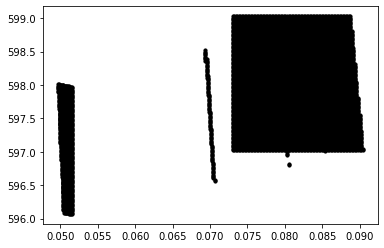

In [62]:
plt.scatter(mg_U2[...,0].ravel(), mg_U2[...,1].ravel(), c=["black"], s=10)


In [547]:
# Initial guess refinement
ref_T = 300
ref_ew = float_mix_functions.u(996, ref_T)
ref_c_v = float_mix_functions.c_v(996, ref_T)
# ref_ew, ref_c_v

"""_T_init = 500

if _T_init < Tc:
  _out = float_mix_functions.prho_sat(_T_init)
  # Hypothetical LV coexistence
  psat = _out["psat"]
  h_rhoa = psat / (R_a * _T_init)
  h_rhom = rho_m0 * (1.0 + (psat - p_m0) / K)
  h_vw = (1/rho_mix - ya / h_rhoa + ym / h_rhom) / yw
  h_x = (h_vw - 1.0/_out["rho_satl"]) / (1.0/_out["rho_satv"] - 1.0/_out["rho_satl"])
  if 0 <= h_x and h_x <= 1:
    # Accept saturation
    _alphaw_init =  yw * rho_mix * h_vw
  elif h_x < 0:
    # Liquid-like
    _alphaw_init = yw * rho_mix / 1000.0
  else:
    # Vapor-like
    _alphaw_init = yw * rho_mix / _out["rho_satv"]
else:
    _alphaw_init = 0.5"""

'_T_init = 500\n\nif _T_init < Tc:\n  _out = float_mix_functions.prho_sat(_T_init)\n  # Hypothetical LV coexistence\n  psat = _out["psat"]\n  h_rhoa = psat / (R_a * _T_init)\n  h_rhom = rho_m0 * (1.0 + (psat - p_m0) / K)\n  h_vw = (1/rho_mix - ya / h_rhoa + ym / h_rhom) / yw\n  h_x = (h_vw - 1.0/_out["rho_satl"]) / (1.0/_out["rho_satv"] - 1.0/_out["rho_satl"])\n  if 0 <= h_x and h_x <= 1:\n    # Accept saturation\n    _alphaw_init =  yw * rho_mix * h_vw\n  elif h_x < 0:\n    # Liquid-like\n    _alphaw_init = yw * rho_mix / 1000.0\n  else:\n    # Vapor-like\n    _alphaw_init = yw * rho_mix / _out["rho_satv"]\nelse:\n    _alphaw_init = 0.5'

In [163]:
_outsat = float_mix_functions.prho_sat(ref_T)
# Latent heat
ref_e_lv = float_mix_functions.u(_outsat["rho_satv"], ref_T) - float_mix_functions.u(_outsat["rho_satl"], ref_T)

In [553]:
''' Test battery '''

vec_yw = np.linspace(0.01, 0.9999, 16) # 125
vec_T = np.linspace(280, 1500, 12) # 130
vec_rhow = np.linspace(0.5, 1050, 16) # 60
vec_ya = np.linspace(0.01, 0.99, 8)

mg_yw, mg_T, mg_rhow, mg_ya = np.meshgrid(
  vec_yw, vec_T, vec_rhow, vec_ya, indexing="ij")

mg_p_target = np.zeros_like(mg_yw)
mg_vol_energy = np.zeros_like(mg_yw)
mg_rho_mix = np.zeros_like(mg_yw)

# Iteratively load complete conservative state
for i, j, k, l in np.ndindex(mg_yw.shape):
  if mg_ya[i,j,k,l] + mg_yw[i,j,k,l] <= 1.0:
    mg_vol_energy[i,j,k,l], mg_rho_mix[i,j,k,l], mg_p_target[i,j,k,l] = \
      prim_to_cons(mg_yw[i,j,k,l], mg_T[i,j,k,l], mg_rhow[i,j,k,l], mg_ya[i,j,k,l])

mg_p_calc = np.empty_like(mg_yw)
mg_T_calc = np.empty_like(mg_yw)
mg_logs   = np.array(np.empty_like(mg_yw), dtype=object)

def iter_solve1(vol_energy, rho_mix, yw, ya):
  msg_list = []

  kern = lambda U0, U1: float_mix_functions.kernel2_WLMA(
    U0, U1,
    vol_energy, rho_mix, yw, ya,
    K, p_m0, rho_m0, c_v_m0, R_a, gamma_a)
  ym = 1.0 - ya - yw

  if ym < 0: \
    return 0.0, 0.0, msg_list
  
  # # Include latent heat is liquid state must be rejected
  # if yw * rho_mix <= rhoc:
  #   e_lv = ref_e_lv
  # else:
  #   e_lv = 0

  # Compute temperature guess
  e_lv = 0
  _e_diff = vol_energy/rho_mix - yw * (ref_ew + e_lv) \
    - ya * R_a / (gamma_a - 1.0) * ref_T - ym * c_v_m0 * ref_T
  _T_init = ref_T + _e_diff \
    / (yw * ref_c_v + ya * R_a / (gamma_a - 1.0) + ym * c_v_m0)
  if _T_init < 273.16:
    _T_init = 273.16

  # Compute stable water volume fraction guess
  if _T_init < Tc:
    _out = float_mix_functions.prho_sat(_T_init)
    # Hypothetical LV coexistence
    psat = _out["psat"]
    h_rhoa = psat / (R_a * _T_init)
    h_rhom = rho_m0 * (1.0 + (psat - p_m0) / K)
    h_vw = (1/rho_mix - ya / h_rhoa + ym / h_rhom) / yw
    h_x = (h_vw - 1.0/_out["rho_satl"]) / (1.0/_out["rho_satv"] - 1.0/_out["rho_satl"])
    if 0 <= h_x and h_x <= 1:
      # Accept saturation
      _alphaw_init =  yw * rho_mix * h_vw
    elif h_x < 0:
      # Liquid-like
      _alphaw_init = yw * rho_mix / 1000.0
    else:
      # Vapor-like
      _alphaw_init = yw * rho_mix / _out["rho_satv"]
  else:
    _alphaw_init = yw * rho_mix / rhoc   
  if _alphaw_init < 0 or _alphaw_init > 1:
    _alphaw_init = 0.5

  # Compute volume constraint minimizer
  _a, _b = 1e-3, 1.0
  for i in range(16):
    _m = 0.5 * (_a + _b)
    if kern(*np.array([_m, _T_init]))[0][1] > 0:
      _b = _m
    else:
      _a = _m
  # Volume candidates
  _alpha_w_candidates = np.unique([
    _alphaw_init, 0.01, .99, 0.5, 1-_alphaw_init, _a])
  # Select best candidate
  _candidate_performance = [
    np.linalg.norm(kern(*np.array([_alpha_w, _T_init]))[0])
    for _alpha_w in _alpha_w_candidates]
  _alphaw_init = _alpha_w_candidates[np.argmin(_candidate_performance)]
  U = np.array([_alphaw_init, _T_init])

  # Newton iterations
  for _k in range(32):
    # Newton step with backtracking
    U, f, msg_list = iterate_backtrack_box(U, kern, append_log=msg_list)
    fnorm = np.linalg.norm(f)
    if fnorm < 1e-12:
      break
    if np.any(np.isnan(f)):
      fnorm = 1e10
      continue
      print(kern(*U), vol_energy, rho_mix, yw)
      raise Exception("Nan encountered, dumping")

  # Compute final U = [alpha_w, T]
  T_calc = U[1]
  rhow = rho_mix * yw / U[0]
  p_calc = float_mix_functions.p(rhow, U[1])
  # if np.any(np.abs(p_calc) > 1e9):
  #   print(kern(*U), vol_energy, rho_mix, yw)
  #   raise Exception("Dumping")
  return p_calc, T_calc, msg_list

for i, j, k, l in np.ndindex(mg_yw.shape):
  # Skip nan inputs
  if np.isnan(mg_yw[i,j,k,l]) \
      or np.isnan(mg_vol_energy[i,j,k,l]) \
      or np.isnan(mg_rho_mix[i,j,k,l]):
    mg_p_calc[i,j,k,l] = 0.0
    mg_T_calc[i,j,k,l] = 0.0
    continue

  # Redefine kernel
  vol_energy = mg_vol_energy[i,j,k,l]
  rho_mix = mg_rho_mix[i,j,k,l]
  yw = mg_yw[i,j,k,l]
  ya = mg_ya[i,j,k,l]

  mg_p_calc[i,j,k,l], mg_T_calc[i,j,k,l], _ = iter_solve1(vol_energy, rho_mix, yw, ya)
  

-1.268048264239925 [5.28343201e-03 3.91036790e+02] [-0.00371955 -0.12758077] [1.0000e-02 2.7316e+02] [1.00000e+00 2.27315e+03]
923.9385567851214
-14752.327129622567


ValueError: Bounds step failed, dumping

In [555]:
np.array([5.28343201e-03, 3.91036790e+02] ) + [-0.00371955,
                                                -0.12758077]

array([1.56388201e-03, 3.90909209e+02])

C:\Users\Fredric\AppData\Local\Temp\ipykernel_17824\325089907.py:2: RuntimeWarning: invalid value encountered in true_divide
  p_reldiffs = np.abs(mg_p_calc / mg_p_target - 1.0)


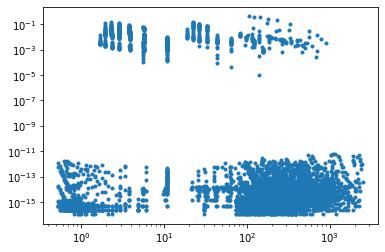

In [467]:
p_diffs = np.abs(mg_p_calc - mg_p_target)
p_reldiffs = np.abs(mg_p_calc / mg_p_target - 1.0)
plt.loglog(mg_rho_mix[np.where(~np.isnan(p_reldiffs))], p_reldiffs[np.where(~np.isnan(p_reldiffs))], '.')


In [468]:
np.nanmax(p_reldiffs)
_ind = np.nanargmax(p_reldiffs.ravel())
mg_p_calc.ravel()[_ind], mg_p_target.ravel()[_ind]

(8768726.243566923, 15080313.91772097)

In [469]:
''' Inspect worst case '''
_ind = np.nanargmax(p_reldiffs.ravel())

# Redefine kernel
vol_energy = mg_vol_energy.ravel()[_ind]
rho_mix = mg_rho_mix.ravel()[_ind]
yw = mg_yw.ravel()[_ind]
ya = mg_ya.ravel()[_ind]
kern = lambda U0, U1: float_mix_functions.kernel2_WLMA(
  U0, U1,
  vol_energy, rho_mix, yw, ya,
  K, p_m0, rho_m0, c_v_m0, R_a, gamma_a)

# # Set best seed (use yw as proxy for alphaw)
# U = np.array([yw, 400])

# Set best seed (use yw as proxy for alphaw)
ym = 1.0 - ya - yw
# Include latent heat is liquid state must be rejected
if yw * rho_mix <= rhoc:
  e_lv = ref_e_lv
else:
  e_lv = 0
# TODO: HACK: skip
e_lv = 0
# Compute energy difference from reference state
_e_diff = vol_energy/rho_mix - yw * (ref_ew + e_lv) \
  - ya * R_a / (gamma_a - 1.0) * ref_T - ym * c_v_m0 * ref_T
_T_init = ref_T + _e_diff \
  / (yw * ref_c_v + ya * R_a / (gamma_a - 1.0) + ym * c_v_m0)
if _T_init < 273.16:
  _T_init = 273.16
if _T_init < Tc:
  _out = float_mix_functions.prho_sat(_T_init)
  # Hypothetical LV coexistence
  psat = _out["psat"]
  h_rhoa = psat / (R_a * _T_init)
  h_rhom = rho_m0 * (1.0 + (psat - p_m0) / K)
  h_vw = (1/rho_mix - ya / h_rhoa + ym / h_rhom) / yw
  h_x = (h_vw - 1.0/_out["rho_satl"]) / (1.0/_out["rho_satv"] - 1.0/_out["rho_satl"])
  if 0 <= h_x and h_x <= 1:
    # Accept saturation
    _alphaw_init =  yw * rho_mix * h_vw
  elif h_x < 0:
    # Liquid-like
    _alphaw_init = yw * rho_mix / 1000.0
  else:
    # Vapor-like
    _alphaw_init = yw * rho_mix / _out["rho_satv"]
else:
    _alphaw_init = yw * rho_mix / rhoc

if _alphaw_init < 0 or _alphaw_init > 1:
  _alphaw_init = 0.5

# Volume constraint minimizer
_a, _b = 1e-3, 1.0
for i in range(16):
  _m = 0.5 * (_a + _b)
  if kern(*np.array([_m, _T_init]))[0][1] > 0:
    _b = _m
  else:
    _a = _m
# Volume candidates
_alpha_w_candidates = np.unique([_alphaw_init, 0.01, .99, 0.5, 1-_alphaw_init, _a])
# Brute force search
_candidate_performance = [
  np.linalg.norm(kern(*np.array([_alpha_w, _T_init]))[0]) for _alpha_w in _alpha_w_candidates]
_alphaw_init = _alpha_w_candidates[np.argmin(_candidate_performance)]
U = np.array([_alphaw_init, _T_init])

# Newton iteration
msg_list = []
seq_list = [U]
for _k in range(16):
  # Newton step with backtracking
  U, f, msg_list = iterate_backtrack_box(U, kern, append_log=msg_list)
  seq_list.append(U)
  fnorm = np.linalg.norm(f)
  if fnorm < 1e-12:
    break
  if np.any(np.isnan(f)):
    fnorm = 1e10
    print(kern(*U), vol_energy, rho_mix, yw)
    raise Exception("Nan encountered, dumping")

# Compute final U = [alpha_w, T]
T_calc = U[1]
rhow = rho_mix * yw / U[0]
p_calc = float_mix_functions.p(rhow, U[1])

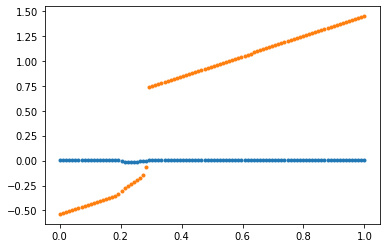

In [382]:
_a_heuristic_test_range = np.linspace(1e-3, 1, 100)
line_F = np.array([kern(*np.array([a, 501.8181818181818]))[0] for a in _a_heuristic_test_range])
plt.plot(_a_heuristic_test_range, line_F, '.')

In [149]:
# Try estimating T from e(T):
# 1. Try sat x in (0,1), which encompasses a range at 

0.9339066666666667

In [330]:
_outsat = float_mix_functions.prho_sat(300)
# Latent heat
e_lv = float_mix_functions.u(_outsat["rho_satv"], 300) - float_mix_functions.u(_outsat["rho_satl"], 300)
e_lv = 0

_e_diff = vol_energy/rho_mix - yw * (ref_ew + e_lv) \
  - ya * R_a / (gamma_a - 1.0) * ref_T - ym * c_v_m0 * ref_T
_T_init = ref_T + _e_diff \
  / (yw * ref_c_v + ya * R_a / (gamma_a - 1.0) + ym * c_v_m0)

e_lv, _e_diff, _T_init

(0, 203880.91850215005, 394.4806672562279)

In [470]:
# Adjust input, solution to the worst case
input = {
  "vol_energy": mg_vol_energy.ravel()[_ind],
  "rho_mix": mg_rho_mix.ravel()[_ind],
  "ya" : mg_ya.ravel()[_ind],
  "yw": mg_yw.ravel()[_ind],
}

solution = {
  "p": mg_p_target.ravel()[_ind],
  "rhow": mg_rhow.ravel()[_ind],
  "T": mg_T.ravel()[_ind],
  "x": 0,
}
solution["alphaw"] = input["rho_mix"] * input["yw"] / solution["rhow"]
if solution["p"] == float_mix_functions.prho_sat(solution["T"])["psat"]:
    _out = float_mix_functions.prho_sat(solution["T"])
    rho_satl, rho_satv = _out["rho_satl"], _out["rho_satv"]
    solution["x"] = (1/solution["rhow"] - 1/rho_satl) / (1/rho_satv - 1/rho_satl)
input, solution, f'p - p_sat = {solution["p"] - float_mix_functions.prho_sat(solution["T"])["psat"]}'
solution

{'p': 15080313.91772097,
 'rhow': 840.1,
 'T': 501.8181818181818,
 'x': 0,
 'alphaw': 0.0012573885259350597}

In [471]:
# Volume constraint minimizer
_a, _b = 1e-3, 1.0
for i in range(16):
  _m = 0.5 * (_a + _b)
  if kern(*np.array([_m, _T_init]))[0][1] > 0:
    _b = _m
  else:
    _a = _m
# Volume candidates
_alpha_w_candidates = np.unique([_alphaw_init, 0.01, .99, 0.5, 1-_alphaw_init, _a])
# Brute force search
_candidate_performance = [
  np.linalg.norm(kern(*np.array([_alpha_w, _T_init]))[0]) for _alpha_w in _alpha_w_candidates]
_alphaw_init = _alpha_w_candidates[np.argmin(_candidate_performance)]
U = np.array([_alphaw_init, _T_init])
U

array([1.24389648e-03, 5.02121105e+02])

In [461]:
_alpha_w_candidates, _candidate_performance

(array([0.01      , 0.02459698, 0.5       , 0.97540302, 0.99      ]),
 [0.3371832469025593,
  0.0011018489548622942,
  1.3679483775272634,
  1.8433603995308616,
  1.8579576913371896])

In [542]:
np.linalg.norm([ 3.56935701e-04 -4.31170375e-01]),\
np.linalg.norm([ 0.00017747 -0.10571506])

(0.430813439299, 0.10553759)

In [486]:
p_calc, mg_p_target.ravel()[_ind], yw, msg_list, seq_list

(11984311.652462898,
 15080313.91772097,
 0.01,
 ['Init   | f: [ 3.56935701e-04 -4.31170375e-01], U:[1.24389648e-03 5.02121105e+02], step: [ 2.28155124e-05 -3.91786911e-01] ',
  'Bounds | f: [ 3.56935701e-04 -4.31170375e-01], U:[1.24389648e-03 5.02121105e+02], step: [ 2.28155124e-05 -3.91786911e-01] ',
  'Backtr | f: [-4.10979333e-06  8.89917370e-01], U:[1.26671200e-03 5.01729318e+02], step: [ 2.28155124e-05 -3.91786911e-01], f/req: 0.8899173701671649/0.3880534703960226',
  'Backtr | f: [ 0.00017747 -0.10571506], U:[1.25530424e-03 5.01925212e+02], step: [ 1.14077562e-05 -1.95893456e-01], f/req: 0.1057152080031223/0.40961199652913494',
  'Init   | f: [ 0.00017747 -0.10571506], U:[1.25530424e-03 5.01925212e+02], step: [ 2.33159864e-06 -1.09365405e-01] ',
  'Bounds | f: [ 0.00017747 -0.10571506], U:[1.25530424e-03 5.01925212e+02], step: [ 2.33159864e-06 -1.09365405e-01] ',
  'Backtr | f: [-4.67325582e-08  1.30799260e-02], U:[1.25763584e-03 5.01815846e+02], step: [ 2.33159864e-06 -1.093654

## Curve fitting e -> T
Although water energy can be isolated, the density plays a large role in temperature determination.

Text(0.5, 0, 'Delta Energy (MJ/kg)')

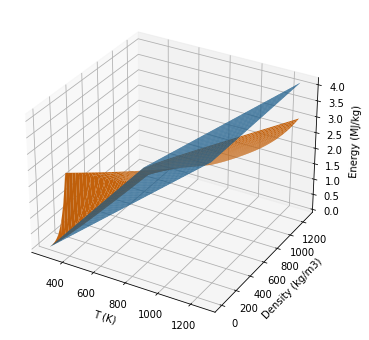

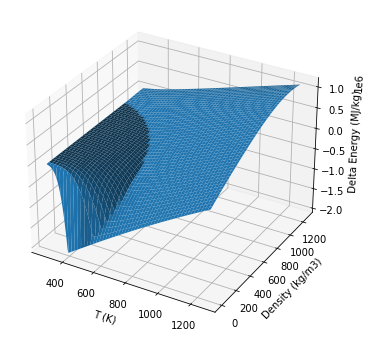

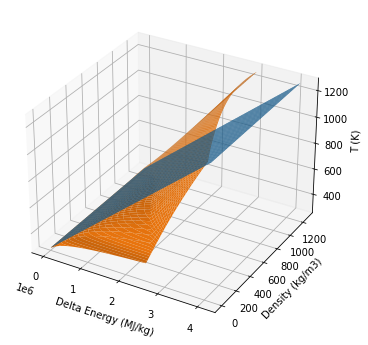

In [301]:
# Check linear-energy coverage
_e_diff = vol_energy/rho_mix - yw * (ref_ew + e_lv) \
  - ya * R_a / (gamma_a - 1.0) * ref_T - ym * c_v_m0 * ref_T
_T_init = ref_T + _e_diff \
  / (yw * ref_c_v + ya * R_a / (gamma_a - 1.0) + ym * c_v_m0)
coverage_T_range = np.linspace(273.16, 1273.15, 350)
coverage_rhow_range = np.linspace(1, 1260, 540)
coverage_mg_T, coverage_mg_rhow = np.meshgrid(
  coverage_T_range, coverage_rhow_range)
coverage_mg_e = np.zeros_like(coverage_mg_T)

# Linear energy estimate
lin_e = lambda T: ref_c_v * (T - ref_T) + ref_ew
# Linear temperature estimate
lin_T = lambda e: ref_T + (e - ref_ew) / ref_c_v

fig = plt.figure(figsize=(6,6))
# plt.subplot(1,2,1)
ax = plt.axes(projection ='3d') 
ax.plot_surface(coverage_mg_T, coverage_mg_rhow, lin_e(coverage_mg_T)/1e6)
for i, j in np.ndindex(coverage_mg_T.shape):
  coverage_mg_e[i,j] = float_mix_functions.u(
    coverage_mg_rhow[i,j], coverage_mg_T[i,j])
ax.plot_surface(coverage_mg_T, coverage_mg_rhow, coverage_mg_e/1e6)
ax.set_xlabel("T (K)")
ax.set_ylabel("Density (kg/m3)")
ax.set_zlabel("Energy (MJ/kg)")

# Linear energy estimate error surface
plt.figure(figsize=(6,6))
ax = plt.axes(projection ='3d') 
ax.plot_surface(coverage_mg_T, coverage_mg_rhow, lin_e(coverage_mg_T) - coverage_mg_e)
ax.set_xlabel("T (K)")
ax.set_ylabel("Density (kg/m3)")
ax.set_zlabel("Delta Energy (MJ/kg)")

# Prediction
plt.figure(figsize=(6,6))
ax = plt.axes(projection ='3d') 
ax.plot_surface(lin_e(coverage_mg_T), coverage_mg_rhow, coverage_mg_T)
ax.plot_surface(coverage_mg_e, coverage_mg_rhow, coverage_mg_T)
ax.set_zlabel("T (K)")
ax.set_ylabel("Density (kg/m3)")
ax.set_xlabel("Delta Energy (MJ/kg)")


In [302]:
# Bound on rhow for p < 1 GPa for T >= 273.16: rhow < 1260
float_mix_functions.p(1258, 660.16)


2493861912.156664

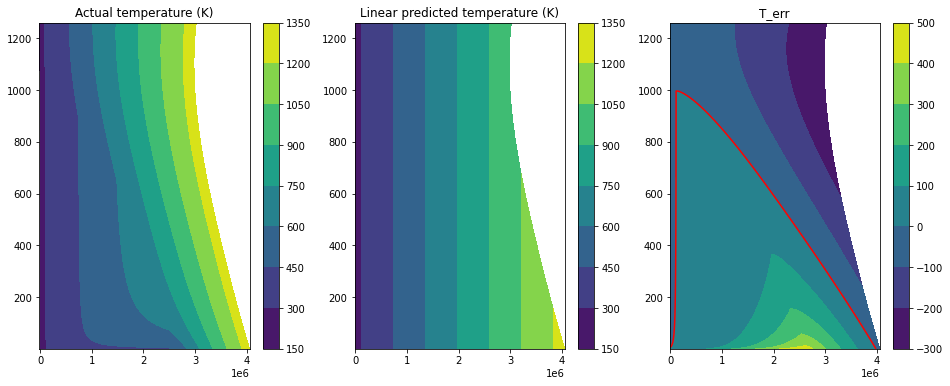

In [303]:
plt.figure(figsize=(16,6))
plt.subplot(1,3,1)
plt.contourf(coverage_mg_e, coverage_mg_rhow, coverage_mg_T)
plt.title("Actual temperature (K)")
plt.colorbar()
plt.subplot(1,3,2)
plt.contourf(coverage_mg_e, coverage_mg_rhow, lin_T(coverage_mg_e))
plt.title("Linear predicted temperature (K)")
plt.colorbar()
plt.subplot(1,3,3)
plt.contourf(coverage_mg_e, coverage_mg_rhow, lin_T(coverage_mg_e) - coverage_mg_T)
plt.colorbar()
plt.title("T_err")
plt.contour(coverage_mg_e, coverage_mg_rhow, lin_T(coverage_mg_e) - coverage_mg_T, levels=[0], colors=["red"])

In [319]:
float_mix_functions.prho_sat(273.16)

{'psat': 611.6547710078996,
 'rho_satl': 999.7925200316239,
 'rho_satv': 0.004854575724778629}

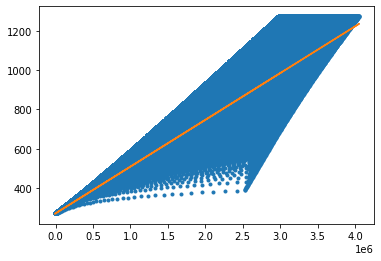

In [321]:
# Collapse T(e)
plt.plot(coverage_mg_e.ravel(), coverage_mg_T.ravel(), '.')
# plt.plot(coverage_mg_e.ravel(), lin_T(coverage_mg_e).ravel(), '.')
plt.plot(coverage_mg_e.ravel(), 273.16 + coverage_mg_e.ravel() / float_mix_functions.c_v(999.7925200316239, 273.16))

In [ ]:
# Plot T envelopes


In [282]:
# Piecewise linear regression
from scipy import optimize

def piecewise_lin(e, T_split, slope_low, slope_high, e_split):
  return np.piecewise(e, [e <= e_split, e > e_split], [
    lambda e: slope_low * (e - e_split) + T_split,
    lambda e: slope_high * (e - e_split) + T_split])

# Global fit
# piecewise_params, piecewise_errs = optimize.curve_fit(piecewise_lin, coverage_mg_e.ravel(), coverage_mg_T.ravel())

# One-way fitting
e_split = 1e6
low_energy_params, piecewise_errs = optimize.curve_fit(
  lambda e, k, c: k*(e - e_split) + c,
  coverage_mg_e.ravel()[np.where(coverage_mg_e.ravel() <= e_split)],
  coverage_mg_T.ravel()[np.where(coverage_mg_e.ravel() <= e_split)])
# Fit high energy part with continuity with low energy part
c = low_energy_params[1]
high_energy_params, piecewise_errs = optimize.curve_fit(
  lambda e, k: k*(e - e_split) + c,
  coverage_mg_e.ravel()[np.where(coverage_mg_e.ravel() > e_split)],
  coverage_mg_T.ravel()[np.where(coverage_mg_e.ravel() > e_split)])

print(low_energy_params)
print(high_energy_params)
piecewise_fit = lambda e: piecewise_lin(
  e, c, low_energy_params[0], high_energy_params[0], e_split)


[2.34332609e-04 5.07987596e+02]
[0.00025986]


In [283]:
piecewise_fit(1e6
)

array(507.98759613)

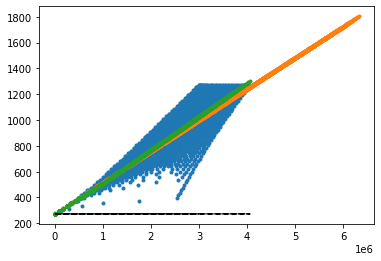

In [284]:
import scipy.stats
linr_res = scipy.stats.linregress(coverage_mg_e.ravel(), coverage_mg_T.ravel(), alternative='two-sided')
plt.plot(coverage_mg_e.ravel(), coverage_mg_T.ravel(), '.')
plt.plot(coverage_mg_elin.ravel(), lin_T(coverage_mg_elin).ravel(), '.')
# plt.plot(coverage_mg_elin.ravel(), linr_res.slope * coverage_mg_elin.ravel() + linr_res.intercept, '.')
plt.plot(coverage_mg_e.ravel(), piecewise_fit(coverage_mg_e.ravel()), '.')

plt.plot(coverage_mg_e.ravel(), 273.16*np.ones_like(coverage_mg_e.ravel()), 'k--')


In [ ]:
# plt.figure(figsize=(12,6))
# plt.subplot(1,2,1)
# plt.contourf(mg_alpha_basin, mg_T_basin, mg_x, levels=np.linspace(0,1e-5,100))
# plt.colorbar()
# plt.subplot(1,2,2)
# plt.contourf(mg_alpha_basin, mg_T_basin, mg_p, levels=20)
# plt.colorbar()
# plt.contour(mg_alpha_basin, mg_T_basin, mg_p, levels=[22.6e6], colors=["red"])


## Basin of attraction

C:\Users\Fredric\AppData\Local\Temp\ipykernel_17824\1317582900.py:68: UserWarning: The following kwargs were not used by contour: 'density'
  plt.contourf(mg_alpha_basin, mg_T_basin, mg_flags, density=2)


Text(0, 0.5, 'T (K)')

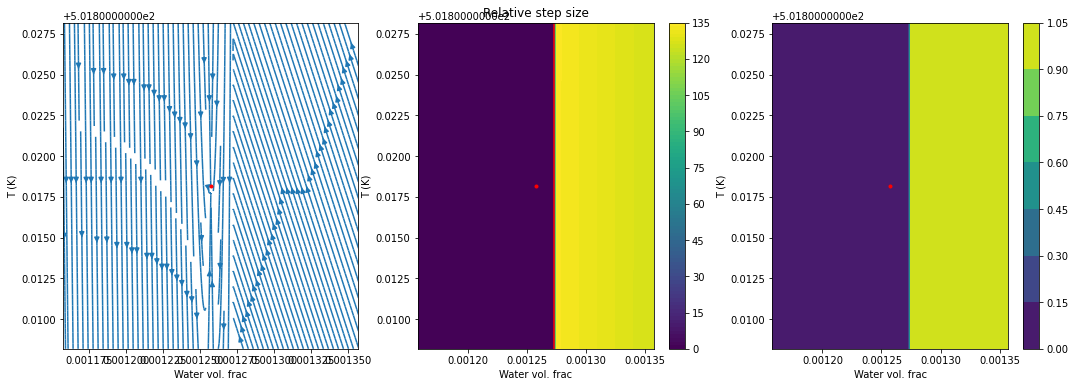

In [531]:
''' Plot basin of attraction '''

_alpha_range = [solution["alphaw"]-0.0001, solution["alphaw"]+0.0001]
_T_range = [solution["T"]-.01, solution["T"]+.01]

_alpha_range = np.clip(_alpha_range, 1e-7, 1)
_T_range = np.clip(_T_range, 273.16, 2273.15)
T_basin_vec = np.linspace(*_T_range, 101)
alpha_basin_vec = np.linspace(*_alpha_range, 100)
mg_alpha_basin, mg_T_basin = np.meshgrid(alpha_basin_vec, T_basin_vec)
mg_f = np.zeros((*mg_alpha_basin.shape, 2))
mg_J = np.zeros((*mg_alpha_basin.shape, 2, 2))
mg_J_fd = np.zeros((*mg_alpha_basin.shape, 2, 2))

mg_df = np.zeros((*mg_alpha_basin.shape, 2))
mg_df_future = np.zeros((*mg_alpha_basin.shape, 2))
mg_flags = np.zeros((*mg_alpha_basin.shape,))
mg_U = np.zeros((*mg_alpha_basin.shape, 2))

for i, j in np.ndindex(mg_T_basin.shape):
  # E, V conditions w.r.t. [alpha_w, T]
  mg_f[i,j,:], mg_J[i,j,...], _, _, mg_flags[i,j] = float_mix_functions.kernel2_WLMA(
    mg_alpha_basin[i,j], mg_T_basin[i,j],
    input["vol_energy"], input["rho_mix"], input["yw"], input["ya"],
    K, p_m0, rho_m0, c_v_m0, R_a, gamma_a)
  mg_df[i,j,:] = (-np.linalg.solve(mg_J[i,j,...], mg_f[i,j,:]))
  mg_U[i,j,:] = [mg_alpha_basin[i,j], mg_T_basin[i,j]]
  # Finite difference J_fd
  dz = 1e-9
  J_fd = np.empty((2,2))
  U_center = np.array([mg_alpha_basin[i,j], mg_T_basin[i,j]])
  J_fd[0,0] = (kern(U_center + [dz/2, 0])[0][0] - kern(U_center + [-dz/2, 0])[0][0]) / dz
  J_fd[0,1] = (kern(U_center + [0, dz/2])[0][0] - kern(U_center + [0, -dz/2])[0][0]) / dz
  J_fd[1,0] = (kern(U_center + [dz/2, 0])[0][1] - kern(U_center + [-dz/2, 0])[0][1]) / dz
  J_fd[1,1] = (kern(U_center + [0, dz/2])[0][1] - kern(U_center + [0, -dz/2])[0][1]) / dz
  mg_J_fd[i,j,...] = J_fd

  # Compute df at the next step
  _f, _J, _, _, _ = float_mix_functions.kernel2_WLMA(
    mg_alpha_basin[i,j] + mg_df[i,j,0], mg_T_basin[i,j] + mg_df[i,j,1],
    input["vol_energy"], input["rho_mix"], input["yw"], input["ya"],
    K, p_m0, rho_m0, c_v_m0, R_a, gamma_a)
  mg_df_future[i,j,:] = -np.linalg.solve(mg_J[i,j,...], 0.5 * (_f + mg_f[i,j,:]))

plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
plt.streamplot(mg_alpha_basin, mg_T_basin, mg_df[...,0], mg_df[...,1], density=2)
plt.plot(solution["alphaw"], solution["T"], '.r')
plt.xlim(mg_alpha_basin.min(), mg_alpha_basin.max())
plt.ylim(mg_T_basin.min(), mg_T_basin.max())

# for _U in seq_list:
  # plt.plot(*_U, '*k')

plt.xlabel("Water vol. frac")
plt.ylabel("T (K)")

plt.subplot(1,3,2)
plt.contourf(mg_alpha_basin, mg_T_basin, np.linalg.norm(mg_df/mg_U, axis=-1), levels=100)
plt.colorbar()
plt.contour(mg_alpha_basin, mg_T_basin, np.linalg.norm(mg_df/mg_U, axis=-1), levels=[1.0], colors=["red"])
plt.plot(solution["alphaw"], solution["T"], '.r')
plt.xlabel("Water vol. frac")
plt.ylabel("T (K)")
plt.title("Relative step size")

plt.subplot(1,3,3)
plt.contourf(mg_alpha_basin, mg_T_basin, mg_flags, density=2)
plt.colorbar()
plt.plot(solution["alphaw"], solution["T"], '.r')
plt.xlabel("Water vol. frac")
plt.ylabel("T (K)")

# plt.figure(figsize=(18,6))
# plt.subplot(1,3,1)
# plt.streamplot(mg_alpha_basin, mg_T_basin, mg_df_future[...,0], mg_df_future[...,1], density=2)
# plt.plot(solution["alphaw"], solution["T"], '.r')
# plt.xlabel("Water vol. frac")
# plt.ylabel("T (K)")

<Figure size 648x648 with 0 Axes>

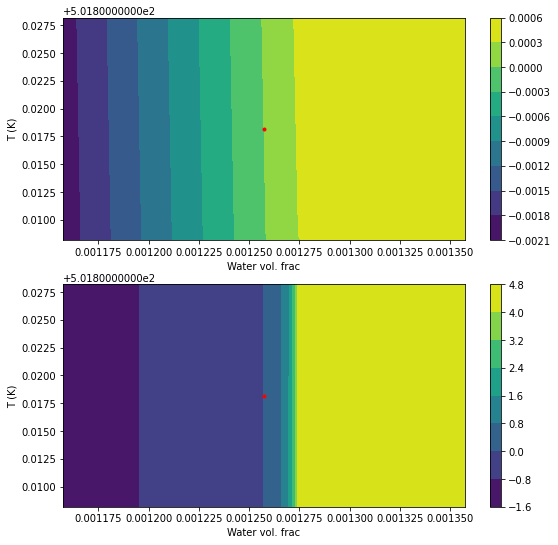

In [534]:
plt.figure(figsize=(9,9))

_output_type = "f"
if _output_type == "J":
  J_access_order = [[0,0], [0,1], [1,0], [1,1]]
  for i in range(4):
    plt.subplot(2,2,1+i)
    plt.contourf(mg_alpha_basin, mg_T_basin, mg_J_fd[...,J_access_order[i][0],J_access_order[i][1]])
    plt.colorbar()
    plt.plot(solution["alphaw"], solution["T"], '.r')
    plt.xlabel("Water vol. frac")
    plt.ylabel("T (K)")

  plt.figure(figsize=(9,9))
  J_access_order = [[0,0], [0,1], [1,0], [1,1]]
  for i in range(4):
    plt.subplot(2,2,1+i)
    plt.contourf(mg_alpha_basin, mg_T_basin, mg_J[...,J_access_order[i][0],J_access_order[i][1]])
    plt.colorbar()
    plt.plot(solution["alphaw"], solution["T"], '.r')
    plt.xlabel("Water vol. frac")
    plt.ylabel("T (K)")

  print("J10, J11: vol frac sum, d/dalpha and d/dT resp.")

  print("J10, J11: vol frac sum, d/dalpha and d/dT resp.")
elif _output_type == "f":
  plt.figure(figsize=(9,9))
  for i in range(2):
    plt.subplot(2,1,1+i)
    plt.contourf(mg_alpha_basin, mg_T_basin, mg_f[...,i])
    plt.colorbar()
    plt.plot(solution["alphaw"], solution["T"], '.r')
    plt.xlabel("Water vol. frac")
    plt.ylabel("T (K)")
else:
  print("bruh")

In [488]:

# alpha_center = seq_list[-1][0]
# T_center = seq_list[-1][1]
alpha_center, T_center = 1.24389648e-03, 5.02121105e+02

(0.001261370239309993, 501.78055923378184)

C:\Users\Fredric\AppData\Local\Temp\ipykernel_17824\2200673819.py:53: UserWarning: The following kwargs were not used by contour: 'density'
  plt.contourf(mg_alpha_basin, mg_T_basin, mg_flags, density=2)


Text(0, 0.5, 'T (K)')

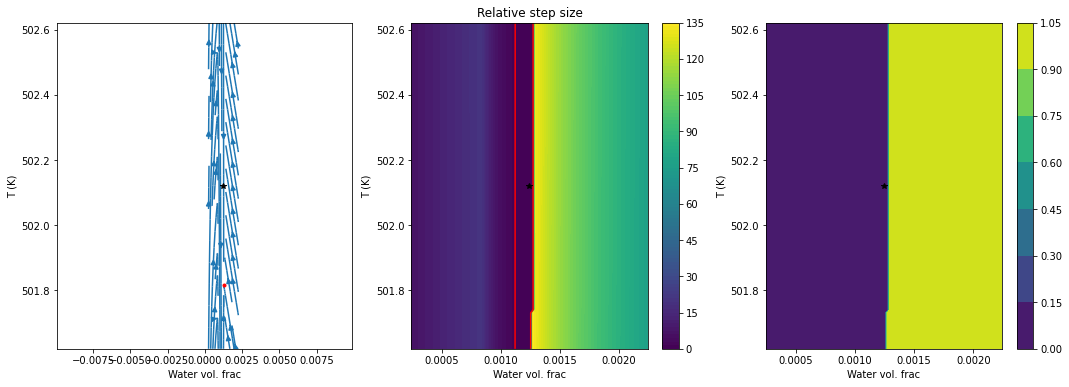

In [535]:
''' Plot basin of attraction of non-solution '''

# alpha_center = seq_list[-1][0]
# T_center = seq_list[-1][1]
alpha_center, T_center = 1.24389648e-03, 5.02121105e+02

T_basin_vec = np.linspace(T_center-.5, T_center+.5, 101)
alpha_basin_vec = np.linspace(np.clip(alpha_center-1e-3, 1e-6, 1), alpha_center+1e-3, 100)

mg_alpha_basin, mg_T_basin = np.meshgrid(alpha_basin_vec, T_basin_vec)
mg_f = np.zeros((*mg_alpha_basin.shape, 2))
mg_J = np.zeros((*mg_alpha_basin.shape, 2, 2))
mg_df = np.zeros((*mg_alpha_basin.shape, 2))
mg_df_future = np.zeros((*mg_alpha_basin.shape, 2))
mg_flags = np.zeros((*mg_alpha_basin.shape,))
mg_U = np.zeros((*mg_alpha_basin.shape, 2))

for i, j in np.ndindex(mg_T_basin.shape):
  # E, V conditions w.r.t. [alpha_w, T]
  mg_f[i,j,:], mg_J[i,j,...], _, _, mg_flags[i,j] = float_mix_functions.kernel2_WLMA(
    mg_alpha_basin[i,j], mg_T_basin[i,j],
    input["vol_energy"], input["rho_mix"], input["yw"], input["ya"],
    K, p_m0, rho_m0, c_v_m0, R_a, gamma_a)
  mg_df[i,j,:] = (-np.linalg.solve(mg_J[i,j,...], mg_f[i,j,:]))
  mg_U[i,j,:] = [mg_alpha_basin[i,j], mg_T_basin[i,j]]

  # Compute df at the next step
  _f, _J, _, _, _ = float_mix_functions.kernel2_WLMA(
    mg_alpha_basin[i,j] + mg_df[i,j,0], mg_T_basin[i,j] + mg_df[i,j,1],
    input["vol_energy"], input["rho_mix"], input["yw"], input["ya"],
    K, p_m0, rho_m0, c_v_m0, R_a, gamma_a)
  mg_df_future[i,j,:] = -np.linalg.solve(mg_J[i,j,...], 0.5 * (_f + mg_f[i,j,:]))

plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
plt.streamplot(mg_alpha_basin, mg_T_basin, mg_df[...,0], mg_df[...,1], density=0.5)
plt.plot(alpha_center, T_center, '*k')
plt.xlabel("Water vol. frac")
plt.ylabel("T (K)")
plt.plot(solution["alphaw"], solution["T"], '.r')


plt.subplot(1,3,2)
plt.contourf(mg_alpha_basin, mg_T_basin, np.linalg.norm(mg_df/mg_U, axis=-1), levels=100)
plt.colorbar()
plt.contour(mg_alpha_basin, mg_T_basin, np.linalg.norm(mg_df/mg_U, axis=-1), levels=[1.0], colors=["red"])
plt.plot(alpha_center, T_center, '*k')
plt.xlabel("Water vol. frac")
plt.ylabel("T (K)")
plt.title("Relative step size")

plt.subplot(1,3,3)
plt.contourf(mg_alpha_basin, mg_T_basin, mg_flags, density=2)
plt.colorbar()
plt.plot(alpha_center, T_center, '*k')
plt.xlabel("Water vol. frac")
plt.ylabel("T (K)")

# plt.figure(figsize=(18,6))
# plt.subplot(1,3,1)
# plt.streamplot(mg_alpha_basin, mg_T_basin, mg_df_future[...,0], mg_df_future[...,1], density=2)
# plt.plot(solution["alphaw"], solution["T"], '.r')
# plt.xlabel("Water vol. frac")
# plt.ylabel("T (K)")

In [538]:
U_center

array([1.24389648e-03, 5.02121105e+02])

Text(0.5, 1.0, 'f norm')

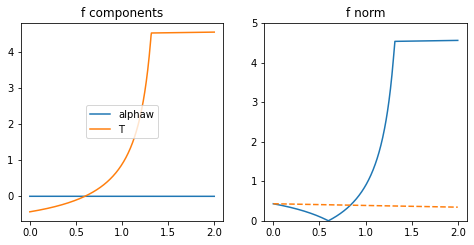

In [539]:
''' Plot line search landscape '''

# Compute state and slope at center
U_center = np.array([alpha_center, T_center])
f_center, J_center, _, _, flag_center = float_mix_functions.kernel2_WLMA(
    alpha_center, T_center,
    input["vol_energy"], input["rho_mix"], input["yw"], input["ya"],
    K, p_m0, rho_m0, c_v_m0, R_a, gamma_a)
# Compute line constraint
dU = -np.linalg.solve(J_center, f_center)
# Define line parametrized by t
line_t = lambda t: U_center + t * dU
_t_range = np.linspace(0,2,500)

kern = lambda U: float_mix_functions.kernel2_WLMA(
    U[0], U[1],
    input["vol_energy"], input["rho_mix"], input["yw"], input["ya"],
    K, p_m0, rho_m0, c_v_m0, R_a, gamma_a)
_f_range = np.array([kern(line_t(t))[0] for t in _t_range])

plt.figure(figsize=(8,8))
plt.subplot(2,2,1)
plt.plot(_t_range, _f_range[:,0])
plt.plot(_t_range, _f_range[:,1])
plt.title("f components")
plt.legend(["alphaw", "T"], loc="center")
plt.subplot(2,2,2)
plt.plot(_t_range, np.linalg.norm(_f_range, axis=-1))
plt.ylim(0, 5)
armijo_line = (1.0 - _t_range * 0.1) * np.linalg.norm(f_center)
plt.plot(_t_range, armijo_line, '--')

plt.title("f norm")

In [503]:
# Finite difference J_fd
dz = 1e-7
J_fd = np.empty((2,2))
J_fd[0,0] = (kern(U_center + [dz/2, 0])[0][0] - kern(U_center + [-dz/2, 0])[0][0]) / dz
J_fd[0,1] = (kern(U_center + [0, dz/2])[0][0] - kern(U_center + [0, -dz/2])[0][0]) / dz
J_fd[1,0] = (kern(U_center + [dz/2, 0])[0][1] - kern(U_center + [-dz/2, 0])[0][1]) / dz
J_fd[1,1] = (kern(U_center + [0, dz/2])[0][1] - kern(U_center + [0, -dz/2])[0][1]) / dz
J_fd, J_center

(array([[ 1.88983262e+01,  2.02780459e-03],
        [ 7.88515227e+04, -1.52745687e-01]]),
 array([[ 1.88983262e+01,  2.02780604e-03],
        [ 7.88508393e+04, -1.52744789e-01]]))

In [485]:
d, t, R
_phirall = float_phi_functions.fused_phir_all(d, t)
dewdd = R * Tc * _phirall.phir_dt
ew = R * Tc * (_phirall.phir_t + float_phi_functions.phi0_t(d, t))
dewdT = -t * t * R * (_phirall.phir_tt + float_phi_functions.phi0_tt(d, t))
pmix = d * rhoc * R * T * (1.0 + d * _phirall.phir_d)
dpdd = rhoc * R * T * (1.0 + 2.0 * d * _phirall.phir_d
        + d * d * _phirall.phir_dd)
dpdT = d * rhoc * R * (
  1.0 + d * _phirall.phir_d - t * d * _phirall.phir_dt)

array([-9.12677102e-07,  2.57922858e-01])

Text(0.5, 1.0, 'f norm')

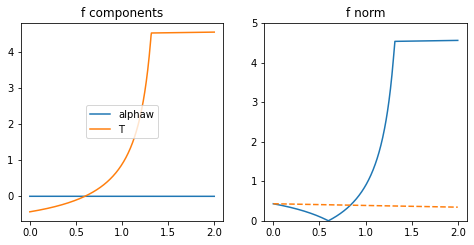

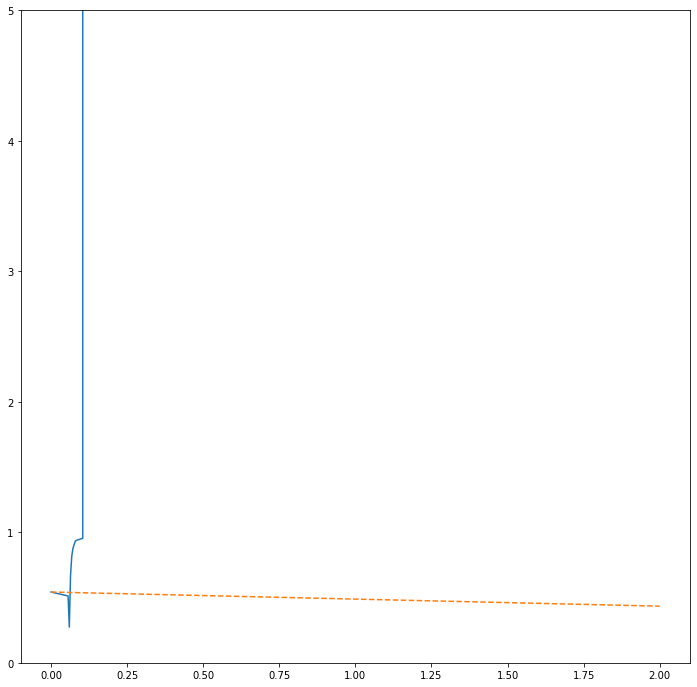

In [58]:
plt.figure(figsize=(12,12))
plt.plot(_t_range, np.linalg.norm(_f_range, axis=-1))
plt.ylim(0, 5)
armijo_line = (1.0 - _t_range * 0.1) * np.linalg.norm(f_center)
plt.plot(_t_range, armijo_line, '--')

In [ ]:
np.linalg.norm(f_along_line) <= (1.0 - a * armijo_c) * fnorm_curr: